<a href="https://colab.research.google.com/github/raihanewubd/selfSupervised/blob/main/AAV_SelfSupervised_06_GoogleNet_2_layer_hidden_projection_head_earlystopping_Barlow_Twins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using fine tuned GoogleNet

In [ ]:
pip install torch_optimizer

In [1]:
import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as T
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import numpy as np
from PIL import Image
from google.colab import drive
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import os
import zipfile
import glob
import shutil
from collections import Counter
from scipy import stats
from collections import Counter

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define dataset path
zip_path = "/content/drive/MyDrive/AAVDATASET/100mV1s_segment_raw.zip"
extract_path = "/content/dataset/"
data_dir = '/content/dataset/train_val_photos'
# Unzip dataset
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [4]:
data_dir = '/content/dataset/train_val_photos'
checkpoint_dir = os.path.join(data_dir, '.ipynb_checkpoints')
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)

In [5]:
# Valid image extensions.
valid_extensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

def is_valid_file(file_path):
    """Filters out hidden files and directories."""
    base_name = os.path.basename(file_path)
    if base_name.startswith('.'):  # Check for hidden files and directories
        return False
    return file_path.lower().endswith(valid_extensions)

# Dictionary to store subfolder name and file count
file_counts = {}

# Get the list of subdirectories (classes)
classes = os.listdir(data_dir)

for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path): # Ensure it's a directory
        # Count files in the subdirectory, filtering for valid files
        count = sum(1 for entry in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, entry)) and is_valid_file(os.path.join(class_path, entry)))
        file_counts[class_name] = count

# Print the file counts
total = 0
for class_name, count in file_counts.items():
    total += count
    print(f"Subfolder '{class_name}': {count} files")
print(f"Total files: {total}")

Subfolder 'Double': 1028 files
Subfolder 'Single': 1088 files
Subfolder 'Empty': 616 files
Total files: 2732


# Pre Training Task

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 209MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
 

Epoch 1/3000 — Loss: 251.9307 — Val Acc: 0.7033 — Time: 412.3s  Saved new best backbone (loss 251.9307) Saved best val model (acc 0.7033)


<ipython-input-6-2109782141>:191: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/3000 — Loss: 172.4090 — Val Acc: 0.6484 — Time: 21.9s  Saved new best backbone (loss 172.4090)
Epoch 3/3000 — Loss: 98.2725 — Val Acc: 0.7985 — Time: 17.7s  Saved new best backbone (loss 98.2725) Saved best val model (acc 0.7985)
Epoch 4/3000 — Loss: 93.0250 — Val Acc: 0.6374 — Time: 16.6s  Saved new best backbone (loss 93.0250)
Epoch 5/3000 — Loss: 77.9751 — Val Acc: 0.7912 — Time: 18.0s  Saved new best backbone (loss 77.9751)
Epoch 6/3000 — Loss: 62.0121 — Val Acc: 0.7875 — Time: 16.9s  Saved new best backbone (loss 62.0121)
Epoch 7/3000 — Loss: 58.9894 — Val Acc: 0.8278 — Time: 17.6s  Saved new best backbone (loss 58.9894) Saved best val model (acc 0.8278)
Epoch 8/3000 — Loss: 54.8206 — Val Acc: 0.8608 — Time: 17.7s  Saved new best backbone (loss 54.8206) Saved best val model (acc 0.8608)
Epoch 9/3000 — Loss: 49.3573 — Val Acc: 0.8425 — Time: 17.1s  Saved new best backbone (loss 49.3573)
Epoch 10/3000 — Loss: 46.5362 — Val Acc: 0.8498 — Time: 16.7s  Saved new best backbone (

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


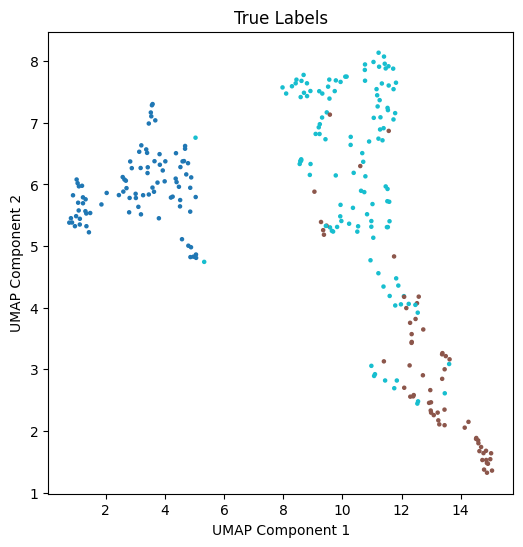

KMeans per-class results
        Correct  Incorrect
Class                     
Double       81          8
Empty        60          2
Single       66         57



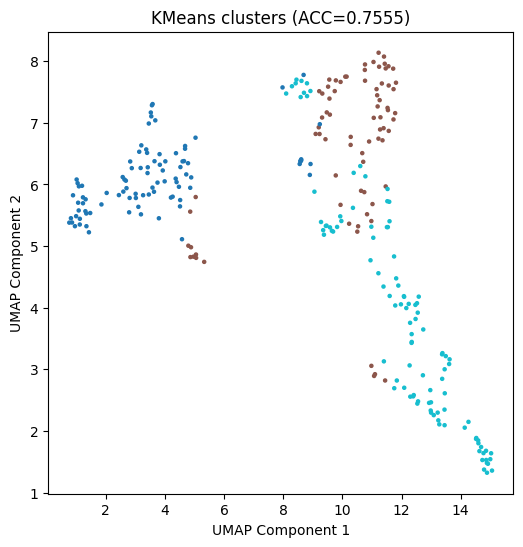

Agglomerative per-class results
        Correct  Incorrect
Class                     
Double       82          7
Empty         0         62
Single      117          6



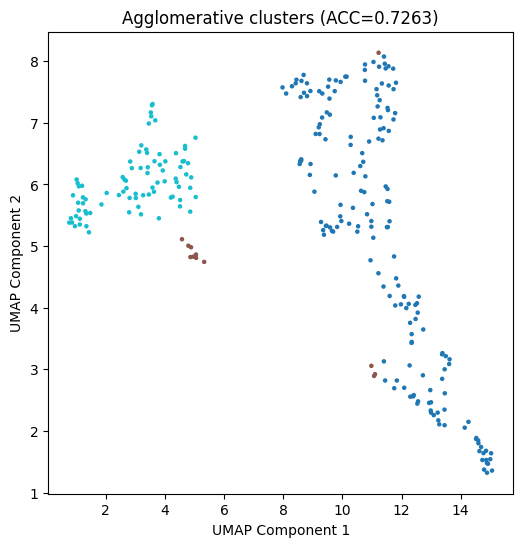

GMM per-class results
        Correct  Incorrect
Class                     
Double       81          8
Empty        60          2
Single       66         57



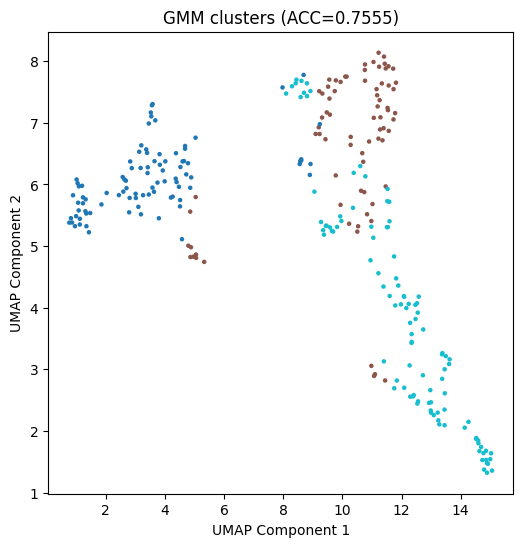

In [6]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms, models
import torchvision.transforms as T
from torch.cuda.amp import GradScaler, autocast
import torch.nn.functional as F
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import umap
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Configuration
DATA_ROOT = "/content/dataset/train_val_photos"
BATCH_SIZE = 256
NUM_WORKERS = 8
LR = 5e-4
EPOCHS = 3000
LAMBDA_BT = 0.005  # Barlow Twins off-diagonal weighting
PROJ_DIM = 256
PATIENCE = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = f"/content/drive/MyDrive/AAVDATASET/models/googlenet_barlow_twins__lr{LR:.4f}_l{LAMBDA_BT:.4f}_e{EPOCHS}_b{BATCH_SIZE}_pd{PROJ_DIM}.pth"
FINAL_MODEL_PATH = MODEL_PATH.replace('.pth', '_final.pth')
INDICES_PATH = '/content/drive/MyDrive/AAVDATASET/models/dataset_indices.xlsx'

torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()

# SimCLR augmentations (used for Barlow Twins)
simclr_transform = T.Compose([
    T.RandomResizedCrop(224, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(0.8, 0.8, 0.8, 0.2),
    T.RandomGrayscale(p=0.2),
    T.RandomRotation(15),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Evaluation transform
eval_transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset and split
full_dataset = datasets.ImageFolder(DATA_ROOT)
full_samples = full_dataset.samples
n = len(full_samples)
train_len = int(0.8 * n)
val_len = int(0.1 * n)
test_len = n - train_len - val_len

generator = torch.Generator().manual_seed(42)
perm = torch.randperm(n, generator=generator).tolist()
train_idxs = perm[:train_len]
val_idxs = perm[train_len:train_len + val_len]
test_idxs = perm[train_len + val_len:]

# Save indices
pd.DataFrame({
    'Train_Indices': pd.Series(train_idxs),
    'Val_Indices': pd.Series(val_idxs),
    'Test_Indices': pd.Series(test_idxs)
}).to_excel(INDICES_PATH, index=False)

train_samples = [full_samples[i] for i in train_idxs]
val_samples = [full_samples[i] for i in val_idxs]
test_samples = [full_samples[i] for i in test_idxs]

# SimCLR Dataset (used for Barlow Twins)
class SimCLRDataset(Dataset):
    def __init__(self, samples_list, transform):
        self.samples = samples_list
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, _ = self.samples[idx]
        img = Image.open(path).convert("RGB")
        x1 = self.transform(img)
        x2 = self.transform(img)
        return x1, x2

# Data loaders
ssl_train_ds = SimCLRDataset(train_samples, simclr_transform)
pretrain_loader = DataLoader(
    ssl_train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True, drop_last=True,
    persistent_workers=True, prefetch_factor=2
)

eval_full_ds = datasets.ImageFolder(DATA_ROOT, transform=eval_transform)
train_eval_ds = Subset(eval_full_ds, train_idxs)
val_eval_ds = Subset(eval_full_ds, val_idxs)
test_eval_ds = Subset(eval_full_ds, test_idxs)

train_loader = DataLoader(
    train_eval_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=2
)
val_loader = DataLoader(
    val_eval_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=2
)
test_loader = DataLoader(
    test_eval_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=2
)

# Barlow Twins loss
def barlow_twins_loss(z1, z2, lambda_bt, bs):
    # Normalize embeddings
    z1 = (z1 - z1.mean(0)) / z1.std(0)
    z2 = (z2 - z2.mean(0)) / z2.std(0)

    # Cross-correlation matrix
    corr = torch.matmul(z1.T, z2) / bs

    # Diagonal loss (invariance term)
    diag_loss = (1 - corr.diag()).pow(2).sum()

    # Off-diagonal loss (decorrelation term)
    off_diag = corr.triu(diagonal=1)
    off_diag_loss = off_diag.pow(2).sum() * lambda_bt

    return diag_loss + off_diag_loss

# Model setup
backbone = models.googlenet(pretrained=True, aux_logits=True)
backbone.aux_logits = False
backbone.aux1 = None
backbone.aux2 = None
feat_dim = backbone.fc.in_features
backbone.fc = nn.Identity()
backbone = backbone.to(DEVICE)

projection_head = nn.Sequential(
    nn.Linear(feat_dim, feat_dim, bias=False),
    nn.BatchNorm1d(feat_dim),
    nn.ReLU(inplace=True),
    nn.Linear(feat_dim, feat_dim, bias=False),
    nn.BatchNorm1d(feat_dim),
    nn.ReLU(inplace=True),
    nn.Linear(feat_dim, PROJ_DIM, bias=True)
).to(DEVICE)

if hasattr(torch, 'compile'):
    backbone = torch.compile(backbone)
    projection_head = torch.compile(projection_head)

optimizer = optim.Adam(
    list(backbone.parameters()) + list(projection_head.parameters()), lr=LR
)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = GradScaler()

num_classes = len(eval_full_ds.classes)
classifier = nn.Linear(feat_dim, num_classes).to(DEVICE)
clf_optimizer = optim.Adam(classifier.parameters(), lr=1e-3)

# Training loop with early stopping
best_loss = float('inf')
best_val_acc = 0.0
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    backbone.train()
    projection_head.train()
    total_loss = 0.0
    start = time.time()

    for x1, x2 in pretrain_loader:
        x1 = x1.to(DEVICE, non_blocking=True)
        x2 = x2.to(DEVICE, non_blocking=True)
        optimizer.zero_grad()
        with autocast():
            z1 = projection_head(backbone(x1))
            z2 = projection_head(backbone(x2))
            loss = barlow_twins_loss(z1, z2, LAMBDA_BT, x1.size(0))
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()

    scheduler.step()

    avg_loss = total_loss / len(pretrain_loader)
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(backbone.state_dict(), MODEL_PATH)
        s = f" Saved new best backbone (loss {best_loss:.4f})"
    else:
        s = ""

    # Linear evaluation
    backbone.eval()
    classifier.train()
    for imgs, labels in train_loader:
        imgs = imgs.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)
        logits = classifier(backbone(imgs))
        loss = F.cross_entropy(logits, labels)
        clf_optimizer.zero_grad()
        loss.backward()
        clf_optimizer.step()

    # Validation
    classifier.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)
            preds = classifier(backbone(imgs)).argmax(1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_acc = correct / total

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'backbone_state_dict': backbone.state_dict(),
            'classifier_state_dict': classifier.state_dict(),
        }, MODEL_PATH.replace('.pth', '_best_val.pth'))
        s += f" Saved best val model (acc {best_val_acc:.4f})"
    else:
        patience_counter += 1

    print(f"Epoch {epoch}/{EPOCHS} — Loss: {avg_loss:.4f} — Val Acc: {val_acc:.4f} — Time: {time.time()-start:.1f}s {s}")

    if patience_counter >= PATIENCE:
        print(f"Early stopping triggered after {epoch} epochs (no improvement in val_acc for {PATIENCE} epochs)")
        break

# Save final model
torch.save(backbone.state_dict(), FINAL_MODEL_PATH)
print(f"Saved final pretrained encoder to {FINAL_MODEL_PATH}")

# Clustering evaluation
backbone.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
backbone = backbone.to(DEVICE).eval()

# Feature extraction
features, labels = [], []
with torch.no_grad():
    for imgs, labs in test_loader:
        feats = backbone(imgs.to(DEVICE)).cpu().numpy()
        features.append(feats)
        labels.append(labs.numpy())

X = np.concatenate(features, axis=0)
y = np.concatenate(labels, axis=0)
class_names = eval_full_ds.classes
print(f"Feature dimension: {X.shape[1]}")

# 2D projection via UMAP
X_2d = umap.UMAP(n_components=2, random_state=42).fit_transform(X)

# True labels visualization
plt.figure(figsize=(6, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, s=5, cmap='tab10')
plt.title("True Labels")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

# Clustering algorithms
algorithms = {
    "KMeans": KMeans(n_clusters=num_classes, init='k-means++', random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=num_classes),
    "GMM": GaussianMixture(n_components=num_classes, covariance_type='full', random_state=42)
}

# Utility: accuracy and mapping
def cluster_accuracy(y_true, y_pred):
    D = max(y_pred.max(), y_true.max()) + 1
    contingency = np.zeros((D, D), dtype=int)
    for i in range(len(y_true)):
        contingency[y_pred[i], y_true[i]] += 1
    row_ind, col_ind = linear_sum_assignment(-contingency)
    accuracy = contingency[row_ind, col_ind].sum() / y_true.size
    return accuracy, dict(zip(row_ind, col_ind))

# Evaluate & visualize
for name, algo in algorithms.items():
    if name == "GMM":
        y_pred = algo.fit_predict(X)
    else:
        y_pred = algo.fit(X).labels_

    acc, mapping = cluster_accuracy(y, y_pred)
    y_mapped = np.vectorize(mapping.get)(y_pred)

    rows = []
    for idx, cls in enumerate(class_names):
        mask = (y == idx)
        correct = (y_mapped[mask] == idx).sum()
        total = mask.sum()
        rows.append({"Class": cls, "Correct": correct, "Incorrect": total - correct})
    df = pd.DataFrame(rows).set_index("Class")
    print(f"{name} per-class results\n{df}\n")

    plt.figure(figsize=(6, 6))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_pred, s=5, cmap='tab10')
    plt.title(f"{name} clusters (ACC={acc:.4f})")
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.show()